<img src="img/uproot-logo-300px.png" alt="Uproot" width="300px" style="margin-bottom: -50px; margin-right: 20px"><font size="5"> is a pure-Python implementation of ROOT I/O.</font>

<br><br>

<img src="img/abstraction-layers.png" width="900px">


# What will this tutorial use?

New versions of both: <b>Uproot 4</b> and <b>Awkward 1</b>. The code is adapted from Jim Pivarski's PyHEP [talk](https://github.com/jpivarski-talks/2020-07-13-pyhep2020-tutorial).

In [1]:
import uproot4
import awkward1 as ak
import numpy as np
from matplotlib import pyplot as plt

Loading files is very easy! We will look at some muon data for now

In [2]:
root = uproot4.open('data/opendata_muons.root')

In [3]:
root

<ReadOnlyDirectory '/' at 0x7fa2a08657f0>

When you open a file, you get its root directory, which has the properties of a Python dict.

You can list its keys.

In [4]:
root.keys()

['Events;1']

(The `;1` wasn't necesssary—it's a "cycle number," which ROOT uses to distinguish objects in the same directory with the same name. If unspecified, you get the highest cycle number.)

In [5]:
root.classnames()

{'Events': 'TTree'}

# Exploring a TTree

In [6]:
tree = root["Events"]
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
PV_npvs              | int32_t                  | AsDtype('>i4')
PV_x                 | float                    | AsDtype('>f4')
PV_y                 | float                    | AsDtype('>f4')
PV_z                 | float                    | AsDtype('>f4')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge       

These are all the branches of the TTree with the type name of the branch (if Uproot can determine it) and its interpretation as an array (if possible).

TTrees also have a dict-like interface.

In [7]:
tree.keys()

['run',
 'luminosityBlock',
 'event',
 'PV_npvs',
 'PV_x',
 'PV_y',
 'PV_z',
 'nMuon',
 'Muon_pt',
 'Muon_eta',
 'Muon_phi',
 'Muon_mass',
 'Muon_charge',
 'Muon_pfRelIso04_all',
 'Muon_tightId']

In [8]:
tree.items()

[('run', <TBranch 'run' at 0x7fa2a078ac70>),
 ('luminosityBlock', <TBranch 'luminosityBlock' at 0x7fa2a0763cd0>),
 ('event', <TBranch 'event' at 0x7fa2a1f93bb0>),
 ('PV_npvs', <TBranch 'PV_npvs' at 0x7fa2a1fbe310>),
 ('PV_x', <TBranch 'PV_x' at 0x7fa2a1fbe9a0>),
 ('PV_y', <TBranch 'PV_y' at 0x7fa2a1fbee50>),
 ('PV_z', <TBranch 'PV_z' at 0x7fa2a5fc0820>),
 ('nMuon', <TBranch 'nMuon' at 0x7fa2a5fc0f40>),
 ('Muon_pt', <TBranch 'Muon_pt' at 0x7fa2a5fc46a0>),
 ('Muon_eta', <TBranch 'Muon_eta' at 0x7fa2a5fc4dc0>),
 ('Muon_phi', <TBranch 'Muon_phi' at 0x7fa2a5fc9520>),
 ('Muon_mass', <TBranch 'Muon_mass' at 0x7fa2a5fc9c70>),
 ('Muon_charge', <TBranch 'Muon_charge' at 0x7fa2a5fcf3d0>),
 ('Muon_pfRelIso04_all', <TBranch 'Muon_pfRelIso04_all' at 0x7fa2a5fcfaf0>),
 ('Muon_tightId', <TBranch 'Muon_tightId' at 0x7fa2a5fcffa0>)]

In [9]:
tree.typenames()

{'run': 'int32_t',
 'luminosityBlock': 'uint32_t',
 'event': 'uint64_t',
 'PV_npvs': 'int32_t',
 'PV_x': 'float',
 'PV_y': 'float',
 'PV_z': 'float',
 'nMuon': 'uint32_t',
 'Muon_pt': 'float[]',
 'Muon_eta': 'float[]',
 'Muon_phi': 'float[]',
 'Muon_mass': 'float[]',
 'Muon_charge': 'int32_t[]',
 'Muon_pfRelIso04_all': 'float[]',
 'Muon_tightId': 'bool[]'}

We can also filter the keys on name or type, wildcards are allowed!

In [10]:
tree.keys(filter_name="P*")

['PV_npvs', 'PV_x', 'PV_y', 'PV_z']

In [11]:
tree.keys(filter_typename="float[]")

['Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_pfRelIso04_all']

# Turning branches into arrays

If a branch has a known interpretation, you can call `array` on it to get an array.

In [12]:
tree["Muon_pt"].array()

<Array [[52, 42.9], [5.02, ... [18.3, 9.72]] type='1000000 * var * float32'>

First thing to notice: this is not a NumPy array. It's because the data have different numbers of values in each element (it's a jagged array). It's an array of arrays with possibly different lengths.

In [13]:
tree["Muon_pt"].array()[:20].tolist()

[[52.00833511352539, 42.85704040527344],
 [5.019948482513428],
 [15.967432022094727, 12.481289863586426],
 [53.42825698852539, 38.43761444091797],
 [7.178549766540527, 5.597340106964111],
 [47.27000427246094, 39.6187858581543],
 [5.050840377807617, 16.29404067993164],
 [17.36166763305664, 26.066043853759766],
 [42.84968566894531, 74.1303482055664],
 [33.52196502685547, 21.316774368286133],
 [13.822826385498047, 27.89041519165039],
 [12.187352180480957],
 [24.41823387145996, 3.560229778289795, 28.34453010559082],
 [22.598438262939453, 9.5486421585083],
 [12.511752128601074, 11.833377838134766, 45.572383880615234],
 [35.032833099365234, 36.92668533325195],
 [39.79318618774414, 39.22704315185547],
 [42.45128631591797, 45.18961715698242],
 [17.6611270904541, 7.474045753479004],
 [6.152662754058838]]

We can (in Uproot 4) _force_ it to be a NumPy array, but it isn't pretty:

In [14]:
tree["Muon_pt"].array(library="np")[:20]

array([array([52.008335, 42.85704 ], dtype=float32),
       array([5.0199485], dtype=float32),
       array([15.967432, 12.48129 ], dtype=float32),
       array([53.428257, 38.437614], dtype=float32),
       array([7.17855, 5.59734], dtype=float32),
       array([47.270004, 39.618786], dtype=float32),
       array([ 5.0508404, 16.29404  ], dtype=float32),
       array([17.361668, 26.066044], dtype=float32),
       array([42.849686, 74.13035 ], dtype=float32),
       array([33.521965, 21.316774], dtype=float32),
       array([13.822826, 27.890415], dtype=float32),
       array([12.187352], dtype=float32),
       array([24.418234 ,  3.5602298, 28.34453  ], dtype=float32),
       array([22.598438,  9.548642], dtype=float32),
       array([12.511752, 11.833378, 45.572384], dtype=float32),
       array([35.032833, 36.926685], dtype=float32),
       array([39.793186, 39.227043], dtype=float32),
       array([42.451286, 45.189617], dtype=float32),
       array([17.661127 ,  7.4740458], dtype=

The data type (`dtype`) of this NumPy array is `object`, meaning that each element it contains is a Python object, namely another NumPy array.

The default is for all arrays to be Awkward arrays, but you can override this by specifying `library`.

The difference is that Awkward arrays interpret nested lists as a second dimension, whereas NumPy object arrays do not:

In [15]:
awkward_array = tree["Muon_pt"].array(library="ak")
numpy_array = tree["Muon_pt"].array(library="np")

In [16]:
# from the first 20 events, get the first item
awkward_array[:20, 0]

<Array [52, 5.02, 16, ... 42.5, 17.7, 6.15] type='20 * float32'>

In [17]:
# doesn't work with NumPy object arrays because contents are not guaranteed to be arrays
numpy_array[:20, 0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Another valid library is Pandas. Pandas has its own way of describing variable length structures (`MultiIndex`).

In [18]:
tree["Muon_pt"].array(library="pd")

entry   subentry
0       0           52.008335
        1           42.857040
1       0            5.019948
2       0           15.967432
        1           12.481290
                      ...    
999997  1            3.336458
999998  0            4.999241
        1           14.161738
999999  0           18.304218
        1            9.717607
Length: 2366345, dtype: float32

# Pluralization

If you look carefully, you'll notice that there's an `array` function and an `arrays` function. The latter gets multiple arrays. In the below example we get that as NumPy arrays, however `library="ak"` and `library="pd"` are also valid options to get Awkward arrays and a pandas dataframe respectively.

In [19]:
# NumPy arrays in a dict
pv_numpy = tree.arrays(filter_name="PV_*", library="np")
pv_numpy

{'PV_npvs': array([ 1,  1,  1, ..., 12, 20,  9], dtype=int32),
 'PV_x': array([0.0722459 , 0.0722459 , 0.0722459 , ..., 0.07219489, 0.07082949,
        0.06881613], dtype=float32),
 'PV_y': array([0.06209353, 0.06209353, 0.06209353, ..., 0.06237721, 0.06023057,
        0.06337257], dtype=float32),
 'PV_z': array([-0.0280992 , -0.0280992 , -0.0280992 , ...,  1.5894414 ,
         0.87497556, -0.6417597 ], dtype=float32)}

In [20]:
pv_numpy["PV_x"]

array([0.0722459 , 0.0722459 , 0.0722459 , ..., 0.07219489, 0.07082949,
       0.06881613], dtype=float32)

Above, we used `filter_name` to select branches that match a pattern. We can also request specific branches:

In [21]:
tree.arrays(["PV_x", "PV_y", "PV_z"])

<Array [{PV_x: 0.0722, ... PV_z: -0.642}] type='1000000 * {"PV_x": float32, "PV_...'>

Or do calculations. (This feature exists for TTree aliases, which can be formulas.) We can even apply cuts!

In [22]:
tree.arrays("PV", aliases={"PV": "sqrt(PV_x**2 + PV_y**2 + PV_z**2)"})

<Array [{PV: 0.0993}, ... {PV: 0.649}] type='1000000 * {"PV": float32}'>

In [23]:
tree.arrays("PV", cut="sqrt(PV_x**2 + PV_y**2) < 0.1", aliases={"PV": "sqrt(PV_x**2 + PV_y**2 + PV_z**2)"})

<Array [{PV: 0.0993}, ... {PV: 0.649}] type='954099 * {"PV": float32}'>

# Multiple files

So far so good, but this was just one small file. Taking a look at `/data/bfys`:

<img src="img/data_bfys.png" width="200px">

What if I have 100+ GBs of ROOT files that I want to open? The Nikhef laptop budget only allowed me to buy a laptop with 16GB RAM, help me!!

## Concatenation

The simplest way to deal with opening multiple files is to read a selection of branches entirely into memory, concatenating them. If you have enough memory, and your files are small enough, go for it!

In [24]:
all_in_memory = uproot4.concatenate("data/uproot-sample-*.root:sample", ["i4", "ai8", "Af8", "str"])
all_in_memory

<Array [{i4: -15, ai8: [, ... str: 'hey-29'}] type='420 * {"i4": int32, "ai8": v...'>

In [25]:
all_in_memory.i4

<Array [-15, -14, -13, -12, ... 11, 12, 13, 14] type='420 * int32'>

In [26]:
all_in_memory.ai8

<Array [[-14, -13, -12], ... [15, 16, 17]] type='420 * var * int64'>

In [27]:
all_in_memory.Af8

<Array [[], [-15], ... 10, 11.1, 12.2, 13.3]] type='420 * var * float64'>

In [28]:
all_in_memory.str

<Array ['hey-0', 'hey-1', ... 'hey-29'] type='420 * string'>

But, often enough, you don't have enough memory. What then? 

## Laziness

One option is to open them as lazy arrays, which opens the files (to get the number of events in each), but doesn't read the data until you use it.

In [29]:
not_in_memory_yet = uproot4.lazy("data/uproot-sample-*.root:sample")
not_in_memory_yet

<Array [{n: 0, b: True, ... str: 'hey-29'}] type='420 * {"n": int32, "b": bool, ...'>

"If it's not in memory, how can I see the values?"

Only the parts of the files (branches and batches of events) that are visible are read. In the above, `n` and `b` from the first file and `str` from the last file must have been read.

Let's get the `Af8` field:

In [30]:
not_in_memory_yet.Af8

<Array [[], [-15], ... 10, 11.1, 12.2, 13.3]] type='420 * var * float64'>

Again, this only read from the first and last files to show the first and last values.

A mathematical operation would cause them all to be read in.

In [31]:
not_in_memory_yet.Af8 + 100

<Array [[], [85], ... [110, 111, 112, 113]] type='420 * var * float64'>

## Controlling the lazy cache

After (part of) a lazy array has been read, how long does it stay in memory? Is it constantly being re-read every time we do a calculation?

By default, a 100 MB cache is associated with the lazy array, but we can provide our own if we want a bigger or smaller one.

In [32]:
cache = uproot4.LRUArrayCache("1 GB")
not_in_memory_yet = uproot4.lazy("data/uproot-sample-*.root:sample", array_cache=cache)

In [33]:
cache

<LRUArrayCache (0/1000000000 bytes full) at 0x7fa25a61afa0>

In [34]:
not_in_memory_yet

<Array [{n: 0, b: True, ... str: 'hey-29'}] type='420 * {"n": int32, "b": bool, ...'>

In [35]:
cache

<LRUArrayCache (1386/1000000000 bytes full) at 0x7fa25a61afa0>

In [36]:
not_in_memory_yet + 100

<Array [{n: 100, b: 101, ab: [, ... 150, 157]}] type='420 * {"n": int32, "b": in...'>

In [37]:
cache

<LRUArrayCache (154084/1000000000 bytes full) at 0x7fa25a61afa0>

What's more, we can clear it when we need to.

In [38]:
cache.clear()

In [39]:
cache

<LRUArrayCache (0/1000000000 bytes full) at 0x7fa25a61afa0>

## Iteration

But often, that's still not enough control.

We don't read arrays into memory for the fun of it, we do it to perform calculations, and lazy arrays don't control which parts of which arrays are in memory during a calculation.

If you're worried about memory, the safest thing to do is to iterate over the data.

In [40]:
for arrays in uproot4.iterate("data/uproot-sample-*.root:sample", ["i4", "Af8"]):
    print(arrays["i4"] + arrays["Af8"])

[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24, 25.1, 26.2, 27.3]]
[[], [-29], [-28, -26.9], [-27, -25.9, ... [23, 24.1, 25.2], [24,

This iteration is _not_ one event at a time. (This set of TTrees has 420 entries.) It's a _chunk of events_ at a time.

In each step, a chunk of events for all specified arrays (`["i4", "Af8"]`) is read. You do your calculation, move on to the next step, and all the previous arrays are dropped. (Only TBasket data carries over if event steps don't line up with TBasket boundaries—a low-level detail.)

# Writing to ROOT files

Uproot 4 cannot write to ROOT files yet: see Uproot 3 documentation.

Some caveats, though:

   * Writing ROOT files with Uproot will always be minimal: histograms and only basic types in TTrees.
   * You won't be able to update an existing file, only make new files.
   * It won't be as fast as writing with ROOT.

The issues involved in _writing_ an established format are considerably different from _reading_. If anyone thinks they can do better, they're welcome to try!

In [41]:
tree = uproot4.open("data/opendata_muons.root:Events") # can also instantly open a tree by adding it after the filepath
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
PV_npvs              | int32_t                  | AsDtype('>i4')
PV_x                 | float                    | AsDtype('>f4')
PV_y                 | float                    | AsDtype('>f4')
PV_z                 | float                    | AsDtype('>f4')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | float[]                  | AsJagged(AsDtype('>f4'))
Muon_eta             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_phi             | float[]                  | AsJagged(AsDtype('>f4'))
Muon_mass            | float[]                  | AsJagged(AsDtype('>f4'))
Muon_charge       

We've already seen that it's "awkward" to deal with the jagged arrays in NumPy. However, they look and feel like records if "zipped" into an Awkward array.

In [42]:
events = tree.arrays(library="ak", how="zip")
events

<Array [{run: 194778, ... ] type='1000000 * {"run": int32, "luminosityBlock": ui...'>

We can use the awkward array data type to encapsulate the structure of the events.

In [43]:
ak.type(events)

1000000 * {"run": int32, "luminosityBlock": uint32, "event": uint64, "PV_npvs": int32, "PV_x": float32, "PV_y": float32, "PV_z": float32, "nMuon": uint32, "Muon": var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso04_all": float32, "tightId": bool}}

`1000000 *` means that there are a million events, `"Muon": var *` means that the contents of the `"Muon"` field are jagged: there's a variable number of them per event.

We could look at a few of these as Python lists and dicts.

In [44]:
ak.to_list(events[:3])

[{'run': 194778,
  'luminosityBlock': 51,
  'event': 12887941,
  'PV_npvs': 1,
  'PV_x': 0.07224589586257935,
  'PV_y': 0.06209353357553482,
  'PV_z': -0.02809920161962509,
  'nMuon': 2,
  'Muon': [{'pt': 52.00833511352539,
    'eta': 1.2523202896118164,
    'phi': 0.8424168229103088,
    'mass': 0.10565836727619171,
    'charge': 1,
    'pfRelIso04_all': -999.0,
    'tightId': False},
   {'pt': 42.85704040527344,
    'eta': 1.6531223058700562,
    'phi': -2.154824733734131,
    'mass': 0.10565836727619171,
    'charge': -1,
    'pfRelIso04_all': -999.0,
    'tightId': False}]},
 {'run': 194778,
  'luminosityBlock': 51,
  'event': 12963969,
  'PV_npvs': 1,
  'PV_x': 0.07224589586257935,
  'PV_y': 0.06209353357553482,
  'PV_z': -0.02809920161962509,
  'nMuon': 1,
  'Muon': [{'pt': 5.019948482513428,
    'eta': 2.1219534873962402,
    'phi': 1.7212640047073364,
    'mass': 0.10565836727619171,
    'charge': 1,
    'pfRelIso04_all': -999.0,
    'tightId': False}]},
 {'run': 194778,
  'lum

But the data are not actually arranged as objects in memory; each field (`"pt"`, `"eta"`, `"phi"`, etc.) is in an array by itself.

This means that structure-changing things like pulling out the kinematics are not expensive computations. (That is, they do not scale with the size of the dataset.)


In [45]:
events["Muon", ["pt", "eta", "phi"]]

<Array [[{pt: 52, eta: 1.25, ... phi: -3.01}]] type='1000000 * var * {"pt": floa...'>

In [46]:
ak.type(events["Muon", ["pt", "eta", "phi"]])

1000000 * var * {"pt": float32, "eta": float32, "phi": float32}

In [47]:
events["Muon", "pz"] = events["Muon", "pt"] * np.sinh(events["Muon", "eta"])

In [48]:
ak.type(events.Muon)

1000000 * var * {"pt": float32, "eta": float32, "phi": float32, "mass": float32, "charge": int32, "pfRelIso04_all": float32, "tightId": bool, "pz": float32}

In [49]:
events.Muon.pz

<Array [[83.5, 108], ... [71.7, 19.1]] type='1000000 * var * float32'>

Since nearly all of you are familiar with NumPy, slicing arrays with boolean arrays is probably familiar to you.

What's new is that the boolean arrays can now be jagged to slice jagged arrays (i.e. cut particles).

In [50]:
events.Muon.pt > 20

<Array [[True, True], ... [False, False]] type='1000000 * var * bool'>

In [51]:
events.Muon[events.Muon.pt > 20]

<Array [[{pt: 52, eta: 1.25, ... [], []] type='1000000 * var * {"pt": float32, "...'>

To cut on events, we need to make the jagged array of booleans into a one-dimensional array of booleans. You can do this with a reducer (such as [ak.sum](https://awkward-array.readthedocs.io/en/latest/_auto/ak.sum.html) or [ak.max](https://awkward-array.readthedocs.io/en/latest/_auto/ak.max.html), but most likely [ak.any](https://awkward-array.readthedocs.io/en/latest/_auto/ak.any.html) and [ak.all](https://awkward-array.readthedocs.io/en/latest/_auto/ak.all.html) for booleans).

In [52]:
ak.any(events.Muon.pt > 20, axis=1)

<Array [True, False, False, ... False, False] type='1000000 * bool'>

In [53]:
events.Muon[ak.any(events.Muon.pt > 20, axis=1)]

<Array [[{pt: 52, eta: 1.25, ... pz: -5.76}]] type='384536 * var * {"pt": float3...'>

# Awkward analysis

Several new operations are needed when arrays can have arbitrary data structures, so the Awkward Array library is best seen as a collection of functions acting on [ak.Array](https://awkward-array.readthedocs.io/en/latest/_auto/ak.Array.html) (the array type).

Probably the most important of these is [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html), which tells us the number of elements in each nested list.

In [54]:
ak.num(events.Muon)

<Array [2, 1, 2, 2, 2, 2, ... 4, 2, 2, 2, 2, 2] type='1000000 * int64'>

That's how many muons there are in each event.

This becomes necessary if we ever try to select the first (and second, etc.) element in each event. Some events might not have any, and this will therefore yield an error.

In [55]:
events.Muon[:, 0]

ValueError: in ListArray64 attempting to get 0, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/0.3.1/src/cpu-kernels/getitem.cpp#L712)

So we can use [ak.num](https://awkward-array.readthedocs.io/en/latest/_auto/ak.num.html) to slice the first dimension and remove the events with 0 muons.

In [56]:
events.Muon[ak.num(events.Muon) > 0, 0]

<Array [{pt: 52, eta: 1.25, ... pz: 71.7}] type='969031 * {"pt": float32, "eta":...'>

## Masking vs cutting

In the nearly two years that physicists have been doing analyses with Awkward Arrays, they've found that cuts are difficult to accumulate. If the first cut changes the length of the array from 1000000 to 969031, boolean arrays that could be applied to the first array can't be applied to the second array.

In practice, they've taken a logical-and of all cuts and apply them at the end, but we can do better: we can mask, rather than cut.

In [57]:
events.Muon.mask[events.Muon.pt > 20]

<Array [[{pt: 52, eta: 1.25, ... [None, None]] type='1000000 * var * ?{"pt": flo...'>

One of the new types that Awkward Array introduces is the "option type," which allows some values to be `None`. (It's a `?` in the type specification.)

## Making regular arrays

If you're feeding your data into a machine learning pipeline, you might need the jaggedness to go away. There are functions for padding jagged arrays (with `None`) so that they reach a desired length (and replacing `None` with a preferred value): [ak.pad_none](https://awkward-array.readthedocs.io/en/latest/_auto/ak.pad_none.html) (and [ak.fill_none](https://awkward-array.readthedocs.io/en/latest/_auto/ak.fill_none.html)).

In [58]:
ak.pad_none(events.Muon.pt, 3, clip=True)

<Array [[52, 42.9, None, ... 18.3, 9.72, None]] type='1000000 * 3 * ?float32'>

In [59]:
ak.fill_none(ak.pad_none(events.Muon.pt, 3, clip=True), 0)

<Array [[52, 42.9, 0], ... [18.3, 9.72, 0]] type='1000000 * 3 * float64'>

When you're plotting something, you usually want to flatten the jaggedness. To get the muon pT distribution we can do:

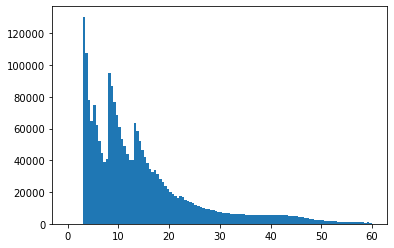

In [60]:
plt.hist(ak.flatten(events.Muon.pt), bins=120, range=(0, 60));

## Awkward combinatorics

We often want to find pairs of particles with some invariant mass. To do that, we need combinatoric functions like [ak.cartesian](https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html) and [ak.combinations](https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html).

<table style="margin-left: 0px">
    <tr style="background: white"><td style="font-size: 1.75em; font-weight: bold; text-align: center">Cartesian product (per event)</td><td style="font-size: 1.75em; font-weight: bold; text-align: center">n-choose-k combinations (per event)</td></tr>
    <tr style="background: white"><td><img src="img/cartoon-cartesian.png"></td><td><img src="img/cartoon-combinations.png"></td></tr>
</table>

In [61]:
muon_pairs = ak.combinations(events.Muon, 2)
muon_pairs

<Array [[({pt: 52, eta: 1.25, ... pz: 19.1})]] type='1000000 * var * ({"pt": flo...'>

In [62]:
m1, m2 = ak.unzip(muon_pairs)
m1, m2

(<Array [[{pt: 52, eta: 1.25, ... pz: 71.7}]] type='1000000 * var * {"pt": float3...'>,
 <Array [[{pt: 42.9, eta: 1.65, ... pz: 19.1}]] type='1000000 * var * {"pt": floa...'>)

In [63]:
masses = np.sqrt(2*m1.pt*m2.pt*(np.cosh(m1.eta - m2.eta) - np.cos(m1.phi - m2.phi)))
masses

<Array [[96.1], [], [18.3, ... [17.9], [14.6]] type='1000000 * var * float32'>

(array([1275., 1203., 1219., 1181., 1134., 1155., 1145., 1140., 1108.,
        1131., 1080., 1050., 1080., 1074., 1015., 1107., 1078., 1068.,
        1021., 1033., 1087., 1113., 1209., 1150., 1234., 1227., 1228.,
        1372., 1372., 1616., 1641., 1831., 1947., 2285., 2542., 3102.,
        3610., 4329., 5290., 5925., 6756., 7099., 6895., 6216., 5476.,
        4533., 3689., 2812., 2302., 1993., 1654., 1330., 1198.,  988.,
         943.,  790.,  702.,  662.,  669.,  601.,  523.,  506.,  487.,
         447.,  450.,  419.,  438.,  367.,  392.,  350.,  352.,  354.,
         354.,  394.,  303.,  342.,  272.,  301.,  265.,  298.]),
 array([ 70. ,  70.5,  71. ,  71.5,  72. ,  72.5,  73. ,  73.5,  74. ,
         74.5,  75. ,  75.5,  76. ,  76.5,  77. ,  77.5,  78. ,  78.5,
         79. ,  79.5,  80. ,  80.5,  81. ,  81.5,  82. ,  82.5,  83. ,
         83.5,  84. ,  84.5,  85. ,  85.5,  86. ,  86.5,  87. ,  87.5,
         88. ,  88.5,  89. ,  89.5,  90. ,  90.5,  91. ,  91.5,  92. ,
         92

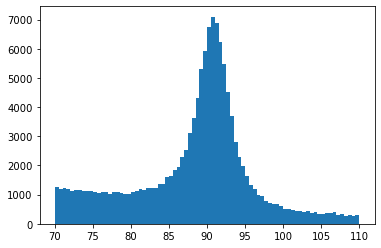

In [64]:
plt.hist(ak.flatten(masses), bins=80, range=(70, 110))

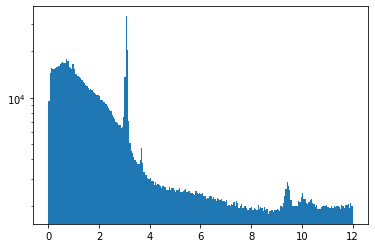

In [65]:
plt.hist(ak.flatten(masses), bins=240, range=(0, 12))
plt.yscale("log")

# Histograms!

But Lex, this is all very nice, but what about my beautiful ROOT plots? What do I do with those? Can I still use those?

Excellent question!

Uproot can read histograms (as well as most other ROOT objects), but it doesn't deal directly with them. The first thing that you do when extracting a histogram is to convert it to another library.

In [66]:
histograms = uproot4.open("data/hepdata-example.root")

In [67]:
histograms.classnames()

{'hpx': 'TH1F', 'hpxpy': 'TH2F', 'hprof': 'TProfile', 'ntuple': 'TNtuple'}

In [68]:
histograms["hpx"].to_boost()

Histogram(Regular(100, -4, 4), storage=Double()) # Sum: 74994.0 (75000.0 with flow)

This is a [boost-histogram](https://github.com/scikit-hep/boost-histogram), a clean design of N-dimensional histograms in the [Boost](https://www.boost.org/doc/libs/release/libs/histogram/doc/html/index.html) C++ library (with Python bindings). Boost-histogram focuses just on **filling and manipulating (e.g. slicing)** histograms.

But we want to plot it, right? There's another library, [mplhep](https://github.com/scikit-hep/mplhep), which focuses just on **plotting** histograms in Matplotlib.

<table style="margin-left: 0px">
    <tr style="background: white">
        <td><img src="img/BoostHistogramCppLogo.png" width="300px" style="margin-right: 20px"></td>
        <td><img src="img/BoostHistogramPythonLogo.png" width="300px" style="margin-right: 20px"></td>
        <td><img src="img/mplhep.png" width="300px"></td>
    </tr>
</table>

Now we can create a histogam in one line!

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7fa25d4278b0>, errorbar=None, legend_artist=None)]

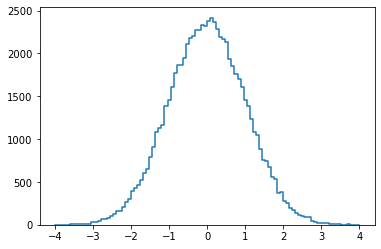

In [69]:
import matplotlib.pyplot as plt
import mplhep as hep

hep.histplot(histograms["hpx"].to_boost())

# mplhep
What is this magic mplhep? mplhep is described as "a set of helpers for matplotlib to more easily produce plots typically needed in HEP as well as style them in way that's compatible with current collaboration requirements (ROOT-like plots for CMS, ATLAS, LHCb, ALICE)." Let's take a look!

Let's start looking at some toy data

In [70]:
H = np.histogram(np.random.normal(2.5, .5, 100), bins=np.arange(0,6, 0.5))
print("Type:", type(H))
h, bins = H
print("Values:", h)
print("Bins:", bins)

Type: <class 'tuple'>
Values: [ 0  2  1 17 34 37  7  2  0  0  0]
Bins: [0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5]


`mplhep.histplot()` for mplhep is what `plt.hist()` is for matplotlib:

#### Primary goal is to stay unobtrusive
- if you know how `plt.hist()` works, `mplhep.histplot()` should behave like you'd expect
- painless transition back if `mpl` grows a proper histogram plotting method
- kwargs you are used to should work

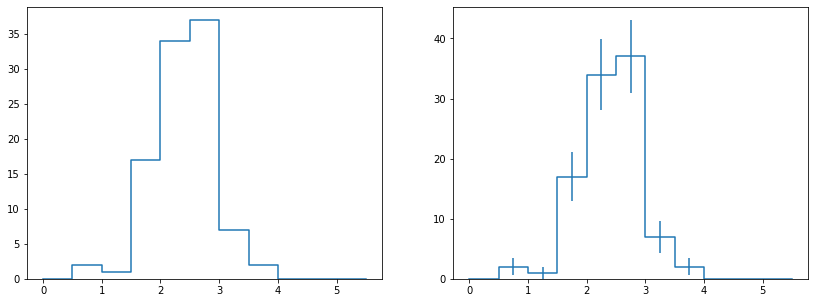

In [71]:
f, axs = plt.subplots(1,2, figsize=(14, 5))

hep.histplot(H, ax=axs[0])
hep.histplot(h, bins, yerr=True, ax=axs[1]);

[ErrorBarArtists(errorbar=<ErrorbarContainer object of 3 artists>)]

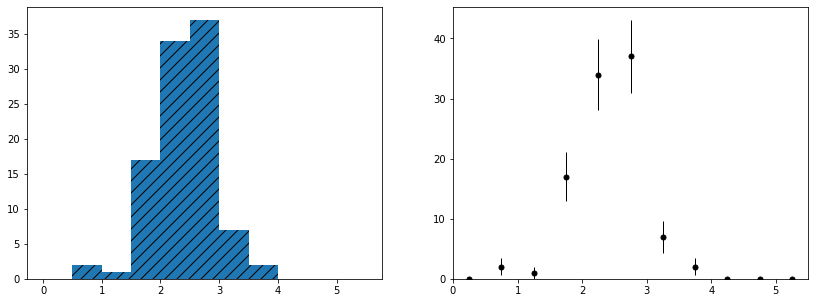

In [72]:
f, axs = plt.subplots(1,2, figsize=(14, 5))

hep.histplot(H, ax=axs[0], histtype='fill', hatch='//')
hep.histplot(H, ax=axs[1], histtype='errorbar', yerr=True, c='black')

Should be easy to use if you're used to matplotlib!

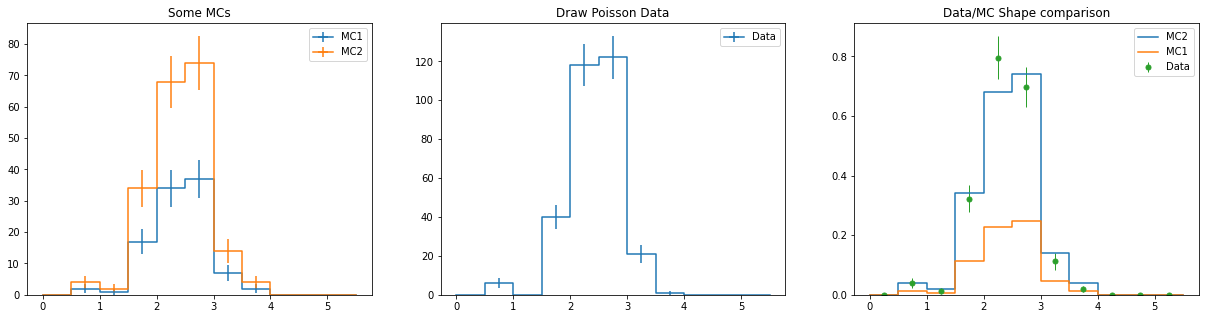

In [73]:
f, axs = plt.subplots(1,3, figsize=(21, 5))

hep.histplot([h, h*2], bins=bins, ax=axs[0], yerr=True, label=["MC1", "MC2"])
hep.histplot(np.random.poisson(h*3), bins=bins, ax=axs[1], yerr=True, label="Data")
hep.histplot([h, h*2], bins=bins, ax=axs[2], stack=True, label=["MC1", "MC2"], density=True)
hep.histplot(np.random.poisson(h*3), bins=bins, ax=axs[2], yerr=True, histtype='errorbar', label="Data", density=True)
for ax in axs:
    ax.legend()
axs[0].set_title("Some MCs")
axs[1].set_title("Draw Poisson Data")
axs[2].set_title("Data/MC Shape comparison"); 

### Let's load some data and see how that works
Maybe we can make some nice Dalitz plots

In [74]:
# Load Dalitz data from the LHCb Starterkit
dalitz_data = uproot4.open("data/dalitz2.root:tree").arrays(library='np')
dalitz_data

{'M2AB': array([   0.,    0.,    0., ..., 1229., 1229., 1229.], dtype=float32),
 'M2AC': array([   0.,    0.,    0., ..., 1709., 1709., 1709.], dtype=float32)}

Let's explore the data, we have the mass squared for the comination of particles A and B and for A and C.

In [75]:
h_AB, bins = np.histogram(dalitz_data["M2AB"], bins=100)
h_AC, bins_AC = np.histogram(dalitz_data["M2AC"], bins=100)

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7fa24dd30490>, errorbar=None, legend_artist=None)]

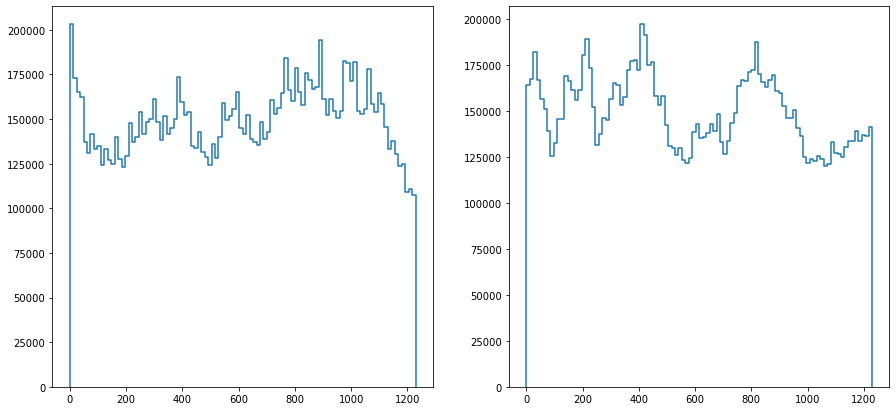

In [76]:
f, axs = plt.subplots(1,2, figsize=(15, 7))
hep.histplot(h_AB,bins,ax=axs[0], label="M2AB")
hep.histplot(h_AC,bins,ax=axs[1], label="M2AC")

Now let's make a 2D plot!

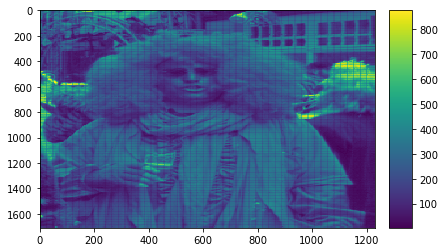

In [77]:
H, xedges, yedges = np.histogram2d(dalitz_data["M2AB"], dalitz_data["M2AC"], bins=256)
hep.hist2dplot(H, xedges, yedges)
plt.gca().invert_yaxis()

## Default plot styles
But this just seems like matplotlib with extra steps? Where is the HEP functionality?

Well,`mplhep` comes with default plot styles! It has ATLAS, CMS, and most interestingly LHCb! It even comes with the LHCb label.

(exptext: Custom Text(0.05, 0.95, 'LHCb'),
 expsuffix: Custom Text(0.05, 0.955, 'Preliminary'))

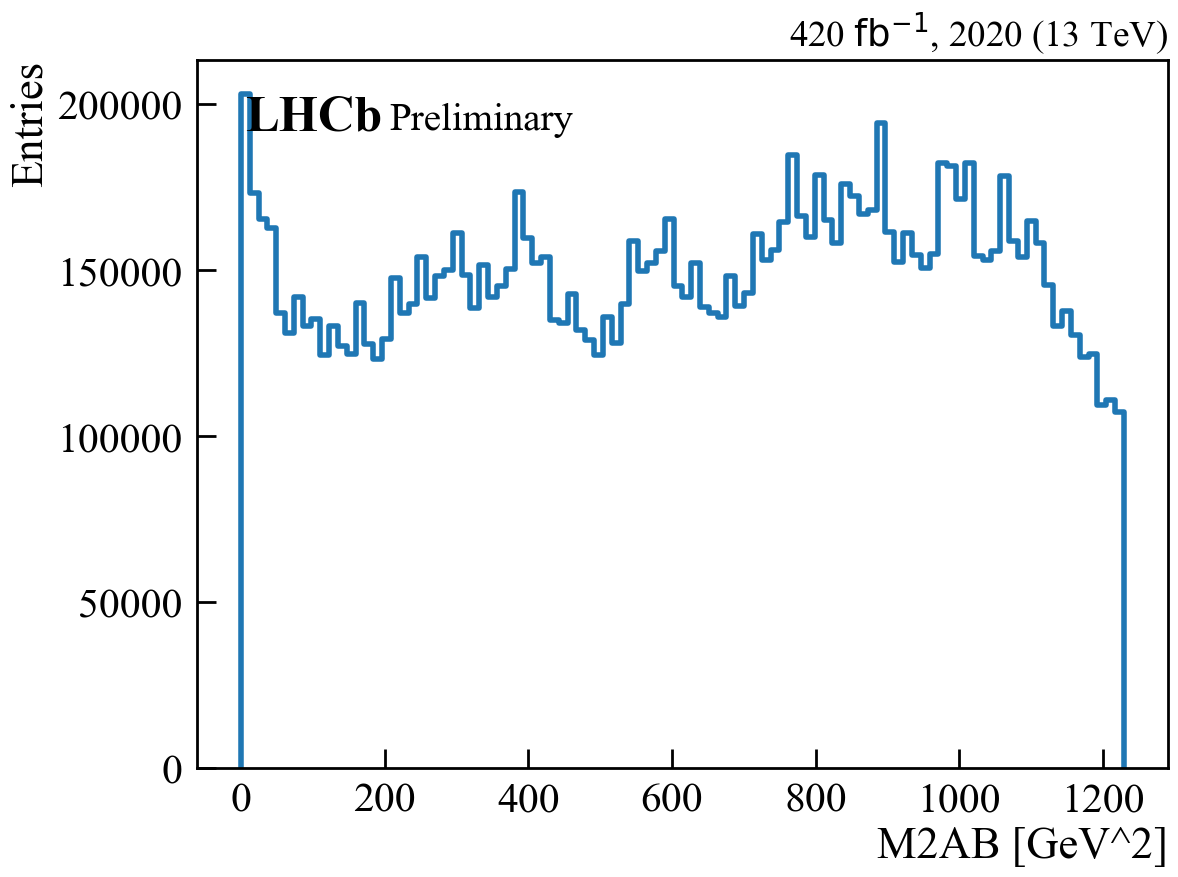

In [78]:
plt.style.use(hep.style.LHCb)
hep.histplot(h_AB,bins, label="M2AB")
plt.xlabel("M2AB [GeV^2]")
plt.ylabel("Entries")
hep.lhcb.label(data=True, paper=False, year=2020, lumi="420")

In [79]:
hep.lhcb.label?

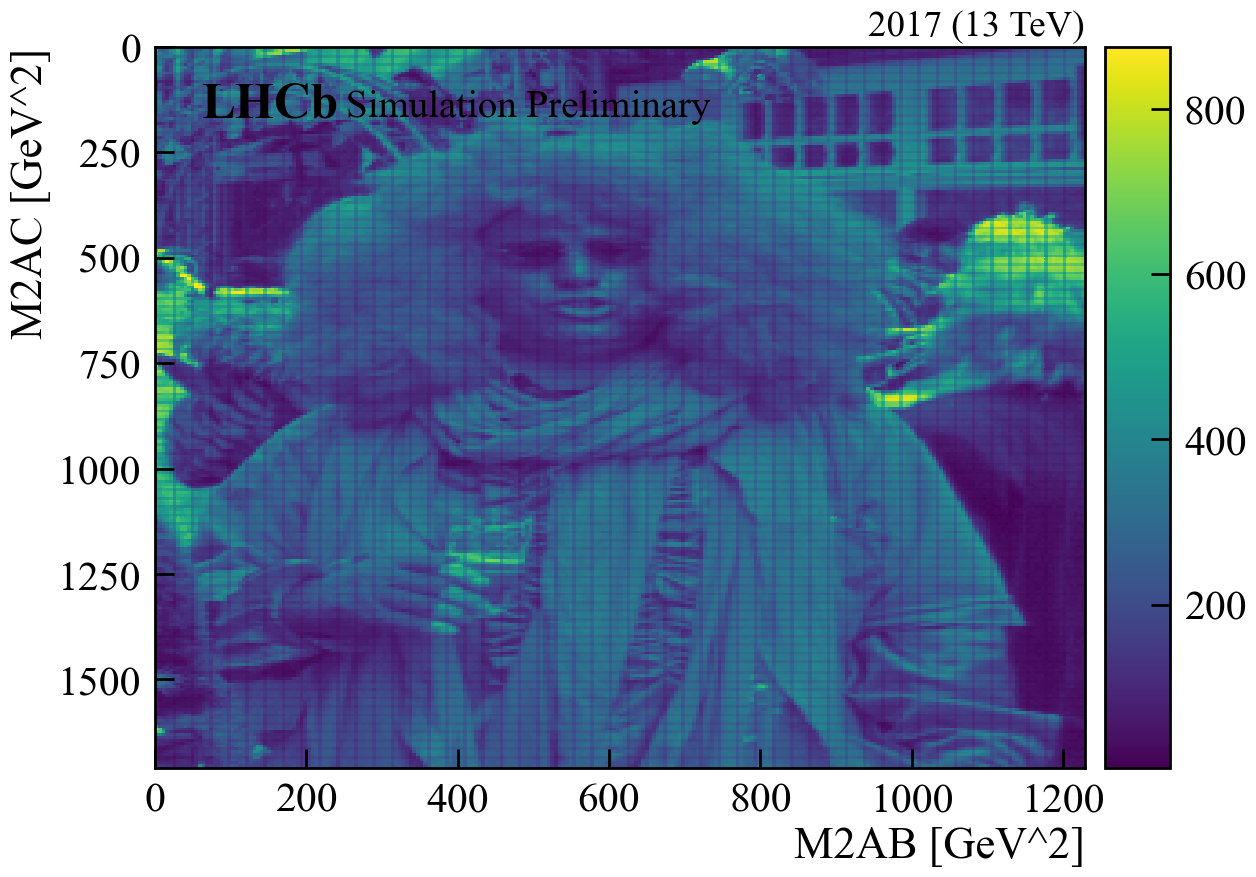

In [80]:
hep.hist2dplot(H, xedges, yedges)
hep.lhcb.label() # default to 2017 simulation=True
plt.xlabel("M2AB [GeV^2]")
plt.ylabel("M2AC [GeV^2]")
plt.gca().invert_yaxis()

We can also make plots look ROOT style, for the ROOT fans under us

(exptext: Custom Text(0.05, 0.95, 'LHCb'),
 expsuffix: Custom Text(0.05, 0.955, 'Preliminary'))

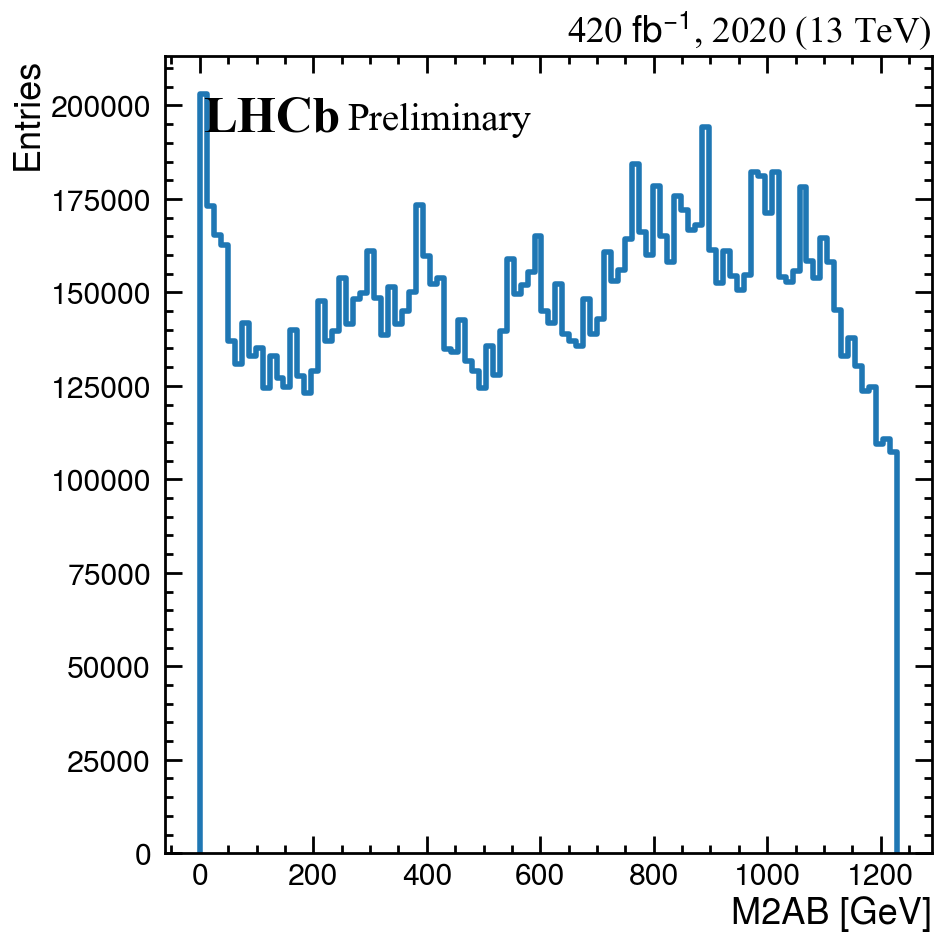

In [81]:
plt.style.use(hep.style.ROOT)
hep.histplot(h_AB,bins, label="M2AB")
plt.xlabel("M2AB [GeV]")
plt.ylabel("Entries")
hep.lhcb.label(data=True, paper=False, year=2020, lumi="420")

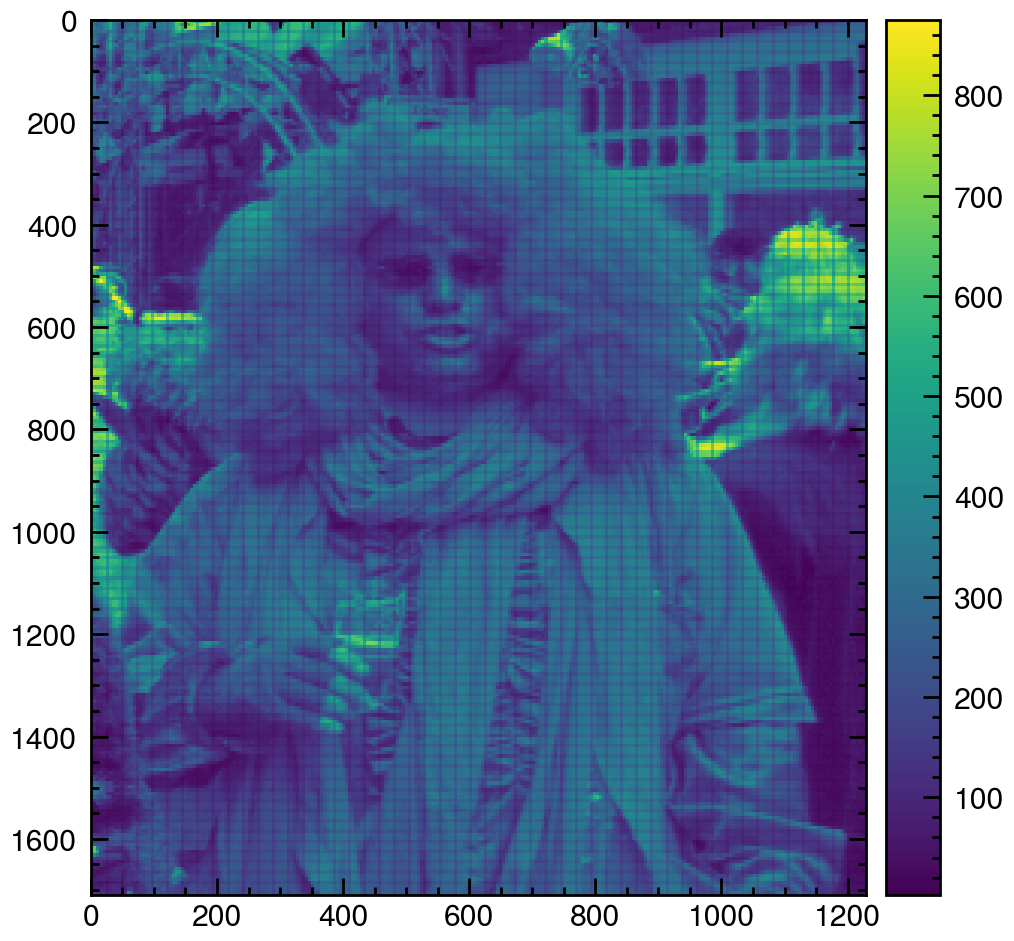

In [86]:
hep.hist2dplot(H, xedges, yedges)
plt.gca().invert_yaxis()


# boost-histogram

Okay, but what if I really like ROOT histograms? NumPy and matplotlib are just now the same, I can't even fill!

The Python ecosystem is missing a good Histogram object. NumPy can perform a histogram operation, but it does not produce an object, and there are limitations and performance issues. The closest thing we have to a histogram is in ROOT.

Let's start with the basics. We will create a histogram using boost-histogram and fill it.

In [87]:
import boost_histogram as bh

In [88]:
data1 = np.random.normal(3.5, 2.5, size=1_000_000) # toy data with 1 million entries
hist1 = bh.Histogram(bh.axis.Regular(40, -2, 10))  # create boost histogram object

Like ROOT, we can fill _after_ we make a histogram, as many times as we want. You can fill single values, but to take advantage of the performance, you should fill with arrays.

In [89]:
hist1.fill(data1)

Histogram(Regular(40, -2, 10), storage=Double()) # Sum: 981455.0 (1000000.0 with flow)

You can see that the histogram has been filled. Let's explicitly check to see how many entries are in the histogram:

In [90]:
hist1.sum()

981455.0

Huh, that's not 1 million!! What happened to the missing items? They are in the underflow and overflow bins:

In [91]:
hist1.sum(flow=True)

1000000.0

Like ROOT, we have overflow bins by default. We can turn them off, but they enable some powerful things like projections.

Let's plot this:

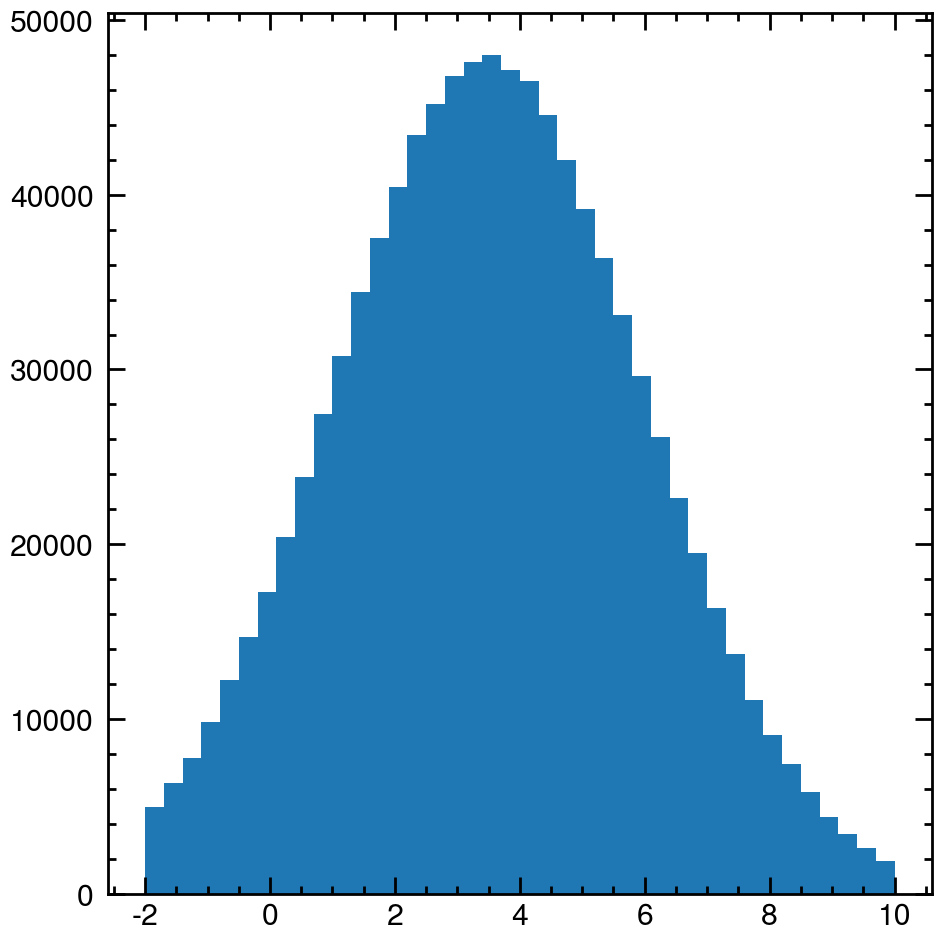

In [92]:
plt.bar(hist1.axes[0].centers, hist1.view(), width=hist1.axes[0].widths);

Note: You can leave off the `.view()` if you want to - histograms conform to the buffer protocol. Also, you can select the axes before or after calling `.centers`; this is very useful for ND histograms.

From now on, let's be lazy, and use mplhep, which natively supports boost-histogram now. See, it all ties in together!

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7fa22eaf2d90>, errorbar=None, legend_artist=None)]

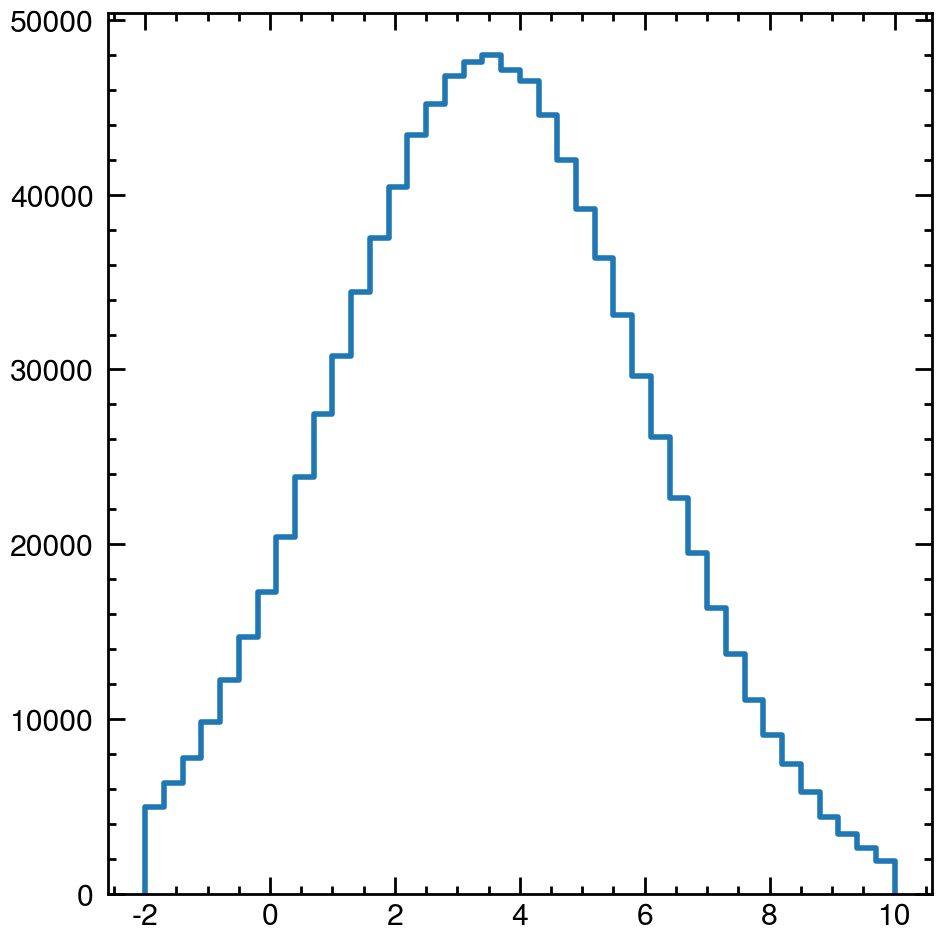

In [93]:
plt.style.use(hep.style.ROOT)
hep.histplot(hist1)

You should think of boost-histogram like NumPy: No plotting is built in, but the data is easy to access.

Unlike ROOT, Histograms are built of of basic building blocks: 1 or more **axes**, and a **storage**. The storage holds **accumulators**, which can be simple doubles or ints, or more complex things that hold extra information about the operation (which might not even be a sum! (generalized histograms).

## Integration with NumPy

To start using this yourself, you don't even need to change your code. Let's try the NumPy adapters.

In [94]:
bins2, edges2 = bh.numpy.histogram(data1, bins=10) # using boost
b2, e2 = np.histogram(data1, bins=10)              # using NumPy

In [95]:
bins2 - b2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [96]:
e2 - edges2

array([ 0.00000000e+00,  0.00000000e+00,  4.44089210e-16, -8.88178420e-16,
       -8.88178420e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.77635684e-15,  0.00000000e+00,  0.00000000e+00])

Not bad! Let's start moving to the boost-histogram API, so we can use the plotting function we just learned about:

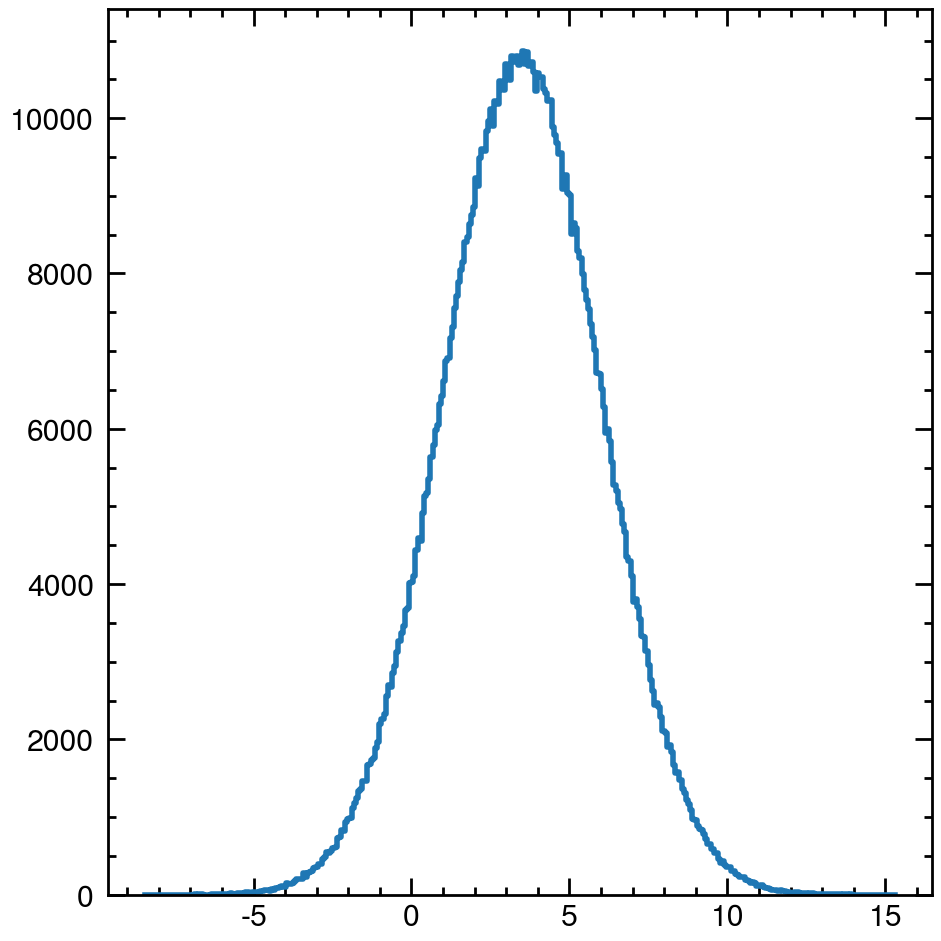

In [97]:
hist2 = bh.numpy.histogram(data1, bins="auto", histogram=bh.Histogram)
hep.histplot(hist2);

Now we can move over to boost-histogram one step at a time! Just to be complete, we can also go back to a Numpy tuple from a Histogram object:

In [98]:
b2p, e2p = bh.numpy.histogram(data1, bins=10, histogram=bh.Histogram).to_numpy()
b2p == b2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

And, while "recently" NumPy optimized 1D regular binning, it still beats optimized NumPy:

In [99]:
%%timeit
bh.numpy.histogram(data1, bins=100)

5.13 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [100]:
%%timeit
np.histogram(data1, bins=100)

9.18 ms ± 73 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Multiple dimension
Now we all like multiple dimension histograms, boost also has a solution for that! Let's reuse the Dalitz data for that.

In [101]:
hist3 = bh.Histogram(bh.axis.Regular(256, 0, 1250,), bh.axis.Regular(256, 0., 1700))

In [102]:
data2d = [dalitz_data['M2AB'], dalitz_data["M2AC"]]

In [103]:
hist3.fill(*data2d)

Histogram(
  Regular(256, 0, 1250),
  Regular(256, 0, 1700),
  storage=Double()) # Sum: 14859288.0 (14938171.0 with flow)

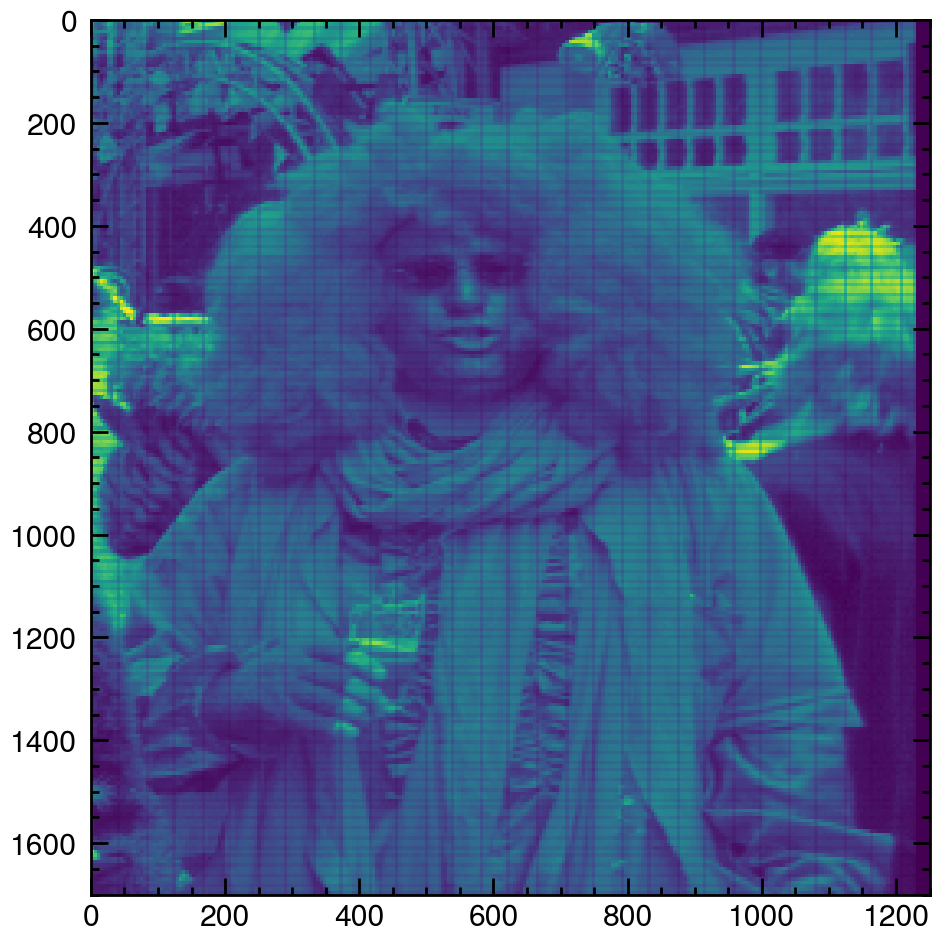

In [104]:
plt.pcolormesh(*hist3.axes.edges.T, hist3.view().T);
plt.gca().invert_yaxis()

This is transposed because of differing indexing conventions. Let's try 3D!

In [105]:
data3d = [np.random.normal(size=1_000_000) for _ in range(3)]

hist3d = bh.Histogram(
    bh.axis.Regular(150, -5, 5),
    bh.axis.Regular(100, -5, 5),
    bh.axis.Regular(100, -5, 5),
)

hist3d.fill(*data3d)

Histogram(
  Regular(150, -5, 5),
  Regular(100, -5, 5),
  Regular(100, -5, 5),
  storage=Double()) # Sum: 999997.0 (1000000.0 with flow)

Let's project to the first two axes:

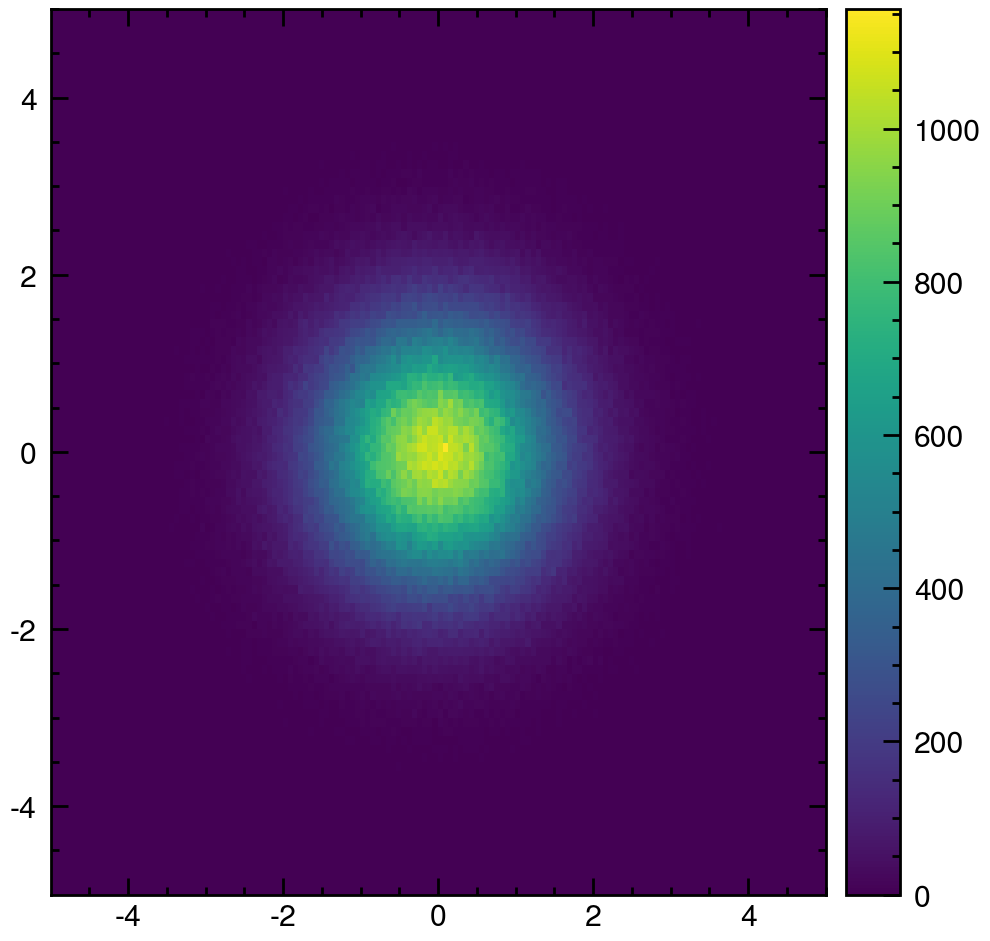

In [106]:
hep.hist2dplot(hist3d[:, :, sum]);

## boost UHI

<img alt="Diagram of UHI" src="img/boost.png"></img> 

Let's explore the boost-histogram UHI syntax. With this we can easily find bin content, get slices, rebin, etc. We will start with a 1D histogram:

In [107]:
h = bh.Histogram(bh.axis.Regular(100, -3.5, 3.5))
data = np.concatenate([
    np.random.normal(-.75,.3, 1_000_000),
    np.random.normal(.75,.3, 750_000),
    np.random.normal(-1.5,.2, 200_000),
])

h.fill(data)

Histogram(Regular(100, -3.5, 3.5), storage=Double()) # Sum: 1950000.0

[StepArtists(step=<matplotlib.lines.Line2D object at 0x7fa22cf62520>, errorbar=None, legend_artist=None)]

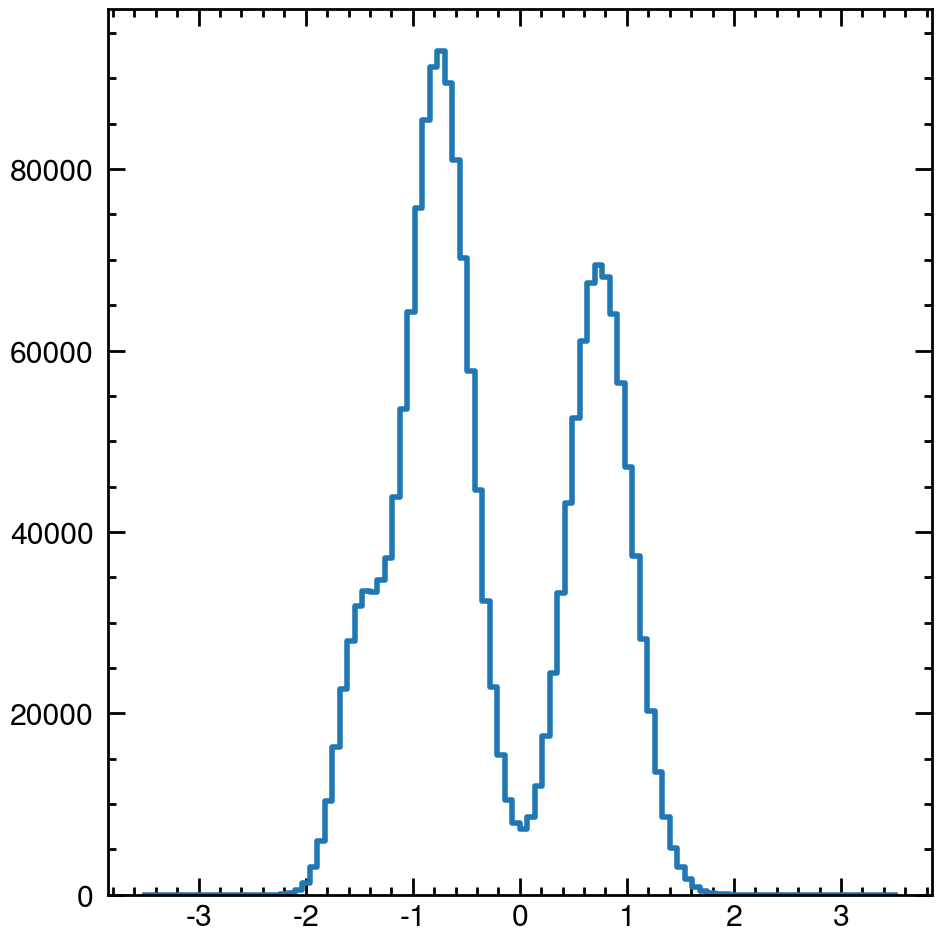

In [108]:
hep.histplot(h)

We can see that we want x from -2 to 0, in *data coordinates*:

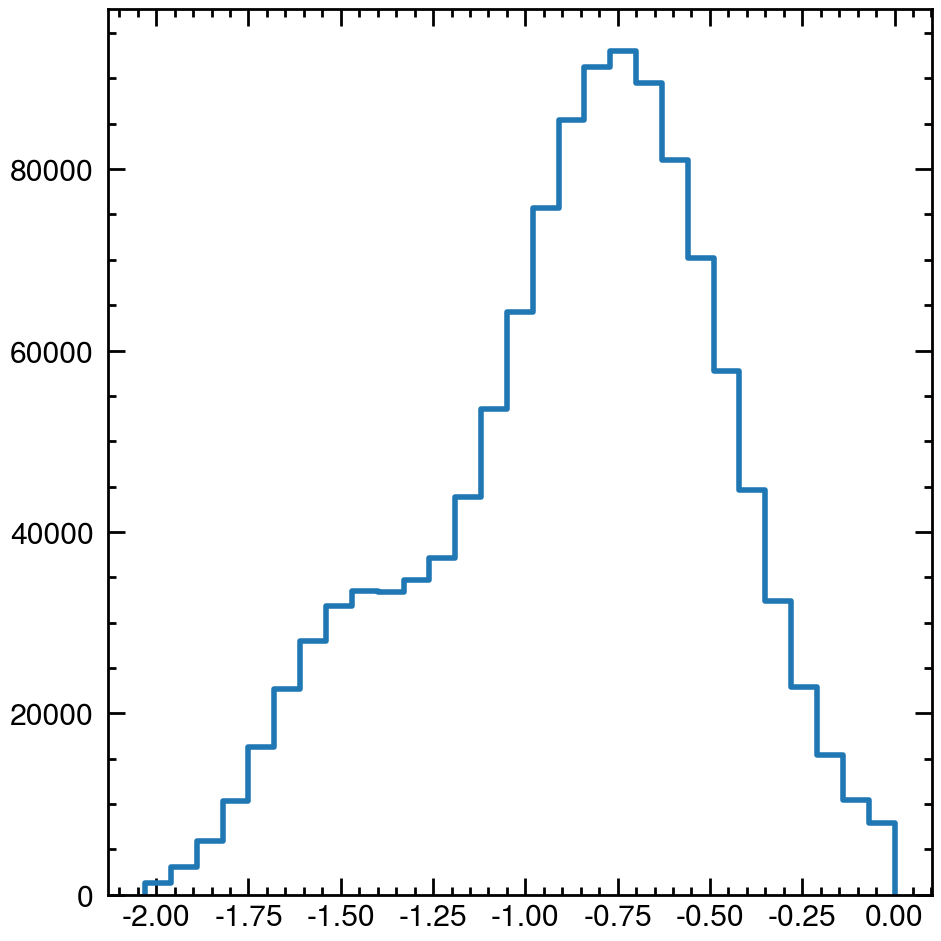

In [109]:
hep.histplot(h[bh.loc(-2):bh.loc(0)]);

What's the contents of a bin?

In [110]:
h[bh.loc(-.75)]

93005.0

How about reducing a histogram? Let's try the previous 2D Histogram

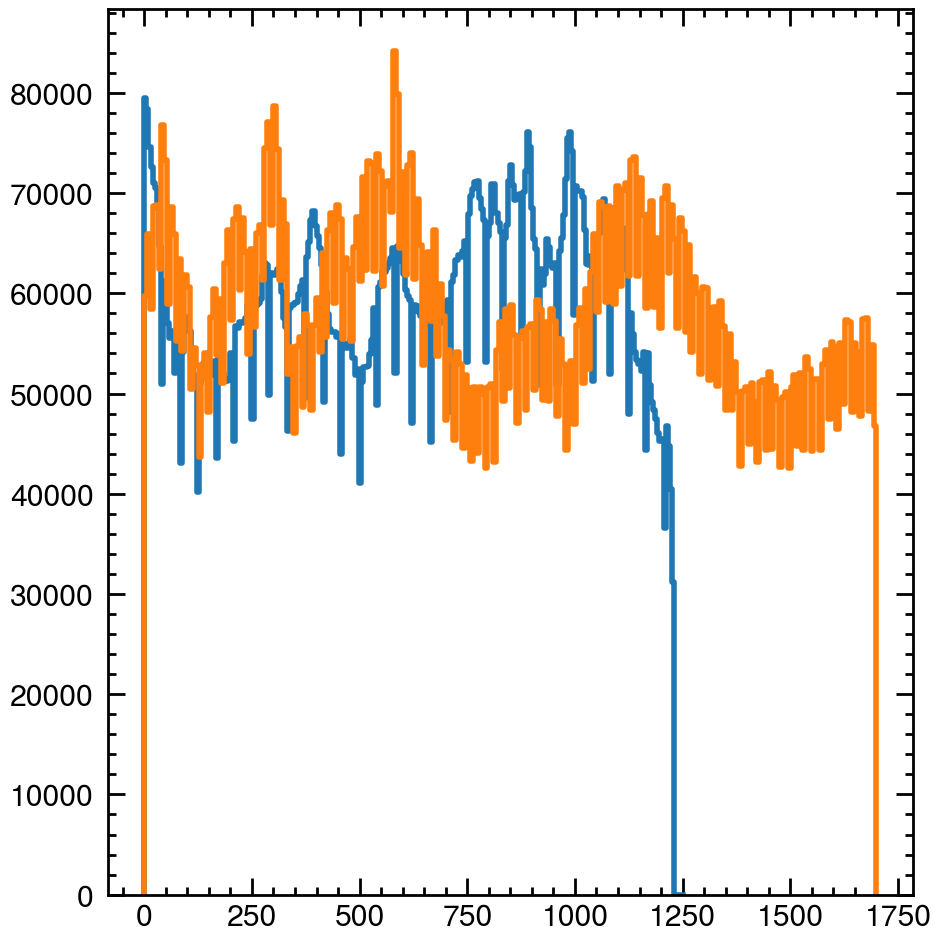

In [111]:
hep.histplot(hist3[:, sum])
hep.histplot(hist3[sum, :]);

Let's look at one part and rebin!

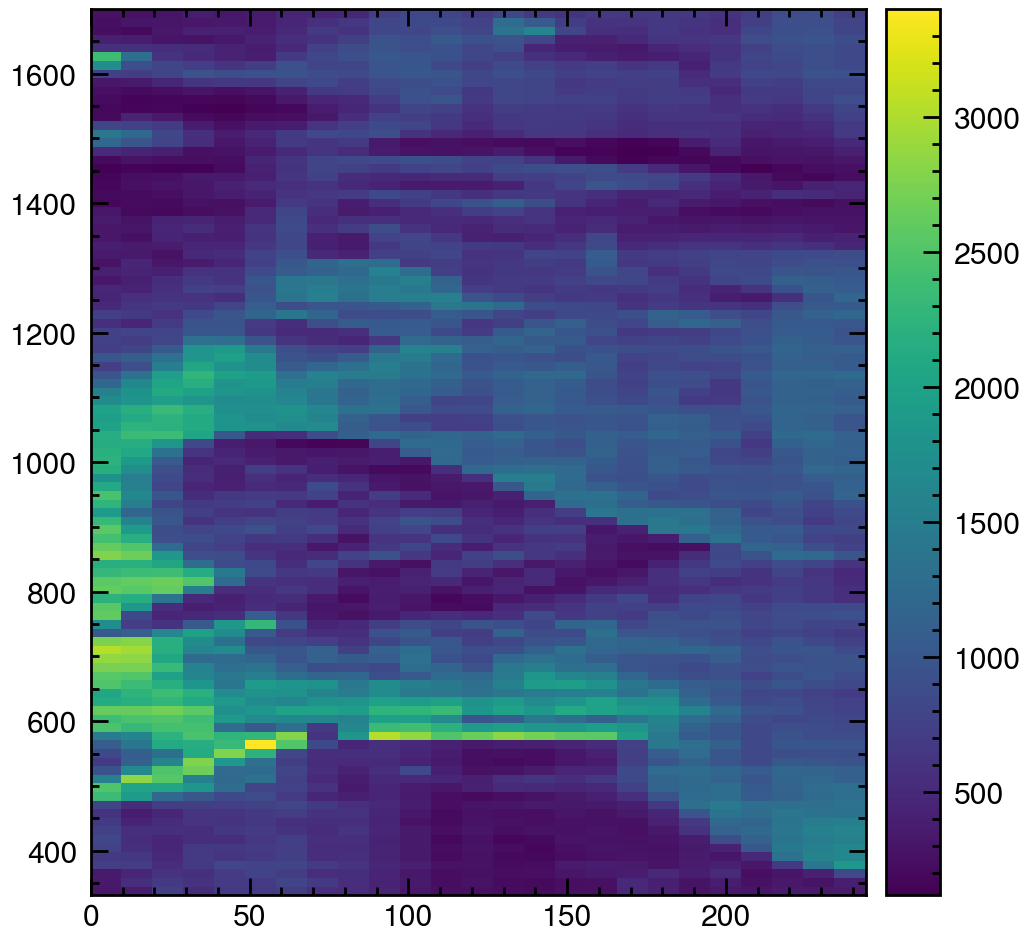

In [112]:
hep.hist2dplot(hist3[: 50 : bh.rebin(2), 50 :: bh.rebin(2)]);

How many entries do we have at M2AB = 500 and M2AC = 600?

In [ ]:
hist3[bh.loc(500), bh.loc(600)]

## No time to cover here:
boost has waaaaay more functions for which we don't have the time today. A small selection is listed below:

- Continuous vs discrete axis
- Variable bin width
- Profile histograms
- Density histograms
- A lot more!

More information can be found on the [GitHub page](https://github.com/scikit-hep/boost-histogram)